# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

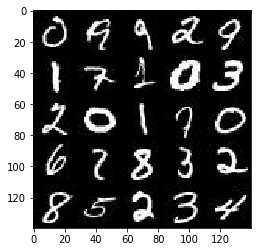

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

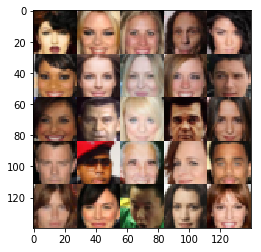

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
    
        fc = tf.layers.dense(z, 7*7*256)
        fc = tf.reshape(fc, (-1, 7, 7, 256))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        
        deconv2 = tf.layers.conv2d_transpose(fc, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2 = tf.maximum(alpha*deconv2, deconv2)
        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_train)
        deconv3 = tf.maximum(alpha*deconv3, deconv3)
        
        logits = tf.layers.conv2d_transpose(deconv3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)        

    return out




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
     
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 4.3065... Generator Loss: 0.2293
Epoch 0/2... Discriminator Loss: 1.3022... Generator Loss: 2.9647
Epoch 0/2... Discriminator Loss: 2.6705... Generator Loss: 0.1699
Epoch 0/2... Discriminator Loss: 2.5032... Generator Loss: 0.1680
Epoch 0/2... Discriminator Loss: 1.2611... Generator Loss: 0.5813
Epoch 0/2... Discriminator Loss: 1.4599... Generator Loss: 0.4546
Epoch 0/2... Discriminator Loss: 0.7278... Generator Loss: 1.2617
Epoch 0/2... Discriminator Loss: 1.4517... Generator Loss: 0.4949
Epoch 0/2... Discriminator Loss: 0.7534... Generator Loss: 1.2261


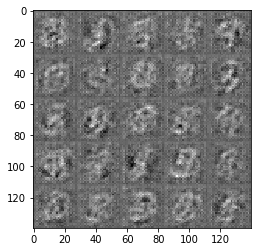

Epoch 0/2... Discriminator Loss: 0.8973... Generator Loss: 1.5824
Epoch 0/2... Discriminator Loss: 0.7957... Generator Loss: 2.4780
Epoch 0/2... Discriminator Loss: 1.1480... Generator Loss: 1.8178
Epoch 0/2... Discriminator Loss: 2.4782... Generator Loss: 0.1394
Epoch 0/2... Discriminator Loss: 1.1566... Generator Loss: 1.0886
Epoch 0/2... Discriminator Loss: 0.5962... Generator Loss: 1.8996
Epoch 0/2... Discriminator Loss: 0.6261... Generator Loss: 1.5524
Epoch 0/2... Discriminator Loss: 1.2627... Generator Loss: 0.5515
Epoch 0/2... Discriminator Loss: 1.3695... Generator Loss: 0.5495
Epoch 0/2... Discriminator Loss: 1.2543... Generator Loss: 0.6046


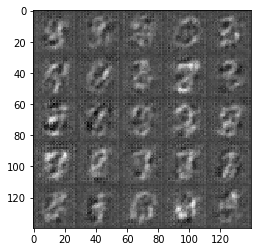

Epoch 0/2... Discriminator Loss: 1.0271... Generator Loss: 0.7979
Epoch 0/2... Discriminator Loss: 0.8781... Generator Loss: 4.1753
Epoch 0/2... Discriminator Loss: 1.1317... Generator Loss: 0.8407
Epoch 0/2... Discriminator Loss: 1.2312... Generator Loss: 0.6072
Epoch 0/2... Discriminator Loss: 0.8190... Generator Loss: 1.3613
Epoch 0/2... Discriminator Loss: 1.3304... Generator Loss: 0.5866
Epoch 0/2... Discriminator Loss: 0.9442... Generator Loss: 1.1635
Epoch 0/2... Discriminator Loss: 0.6319... Generator Loss: 1.4824
Epoch 0/2... Discriminator Loss: 0.7549... Generator Loss: 1.2162
Epoch 0/2... Discriminator Loss: 0.6121... Generator Loss: 1.7906


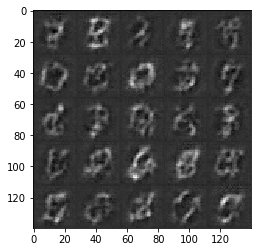

Epoch 0/2... Discriminator Loss: 1.8225... Generator Loss: 0.3274
Epoch 0/2... Discriminator Loss: 1.1572... Generator Loss: 0.8209
Epoch 0/2... Discriminator Loss: 0.8211... Generator Loss: 1.2234
Epoch 0/2... Discriminator Loss: 0.7258... Generator Loss: 1.3552
Epoch 0/2... Discriminator Loss: 0.7370... Generator Loss: 1.2317
Epoch 0/2... Discriminator Loss: 0.4622... Generator Loss: 3.1638
Epoch 0/2... Discriminator Loss: 0.5657... Generator Loss: 1.9999
Epoch 0/2... Discriminator Loss: 0.4494... Generator Loss: 2.5976
Epoch 0/2... Discriminator Loss: 0.4409... Generator Loss: 2.8220
Epoch 0/2... Discriminator Loss: 0.4817... Generator Loss: 2.4277


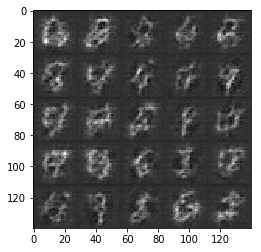

Epoch 0/2... Discriminator Loss: 0.5770... Generator Loss: 1.7696
Epoch 0/2... Discriminator Loss: 0.8717... Generator Loss: 1.3000
Epoch 0/2... Discriminator Loss: 0.7247... Generator Loss: 1.6279
Epoch 0/2... Discriminator Loss: 0.6309... Generator Loss: 1.7213
Epoch 0/2... Discriminator Loss: 0.4297... Generator Loss: 2.7396
Epoch 0/2... Discriminator Loss: 0.6192... Generator Loss: 1.6290
Epoch 0/2... Discriminator Loss: 0.4924... Generator Loss: 2.1144
Epoch 0/2... Discriminator Loss: 0.4275... Generator Loss: 3.1342
Epoch 0/2... Discriminator Loss: 0.6382... Generator Loss: 1.4698
Epoch 0/2... Discriminator Loss: 0.3525... Generator Loss: 4.4284


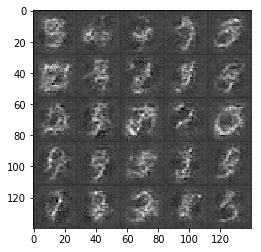

Epoch 0/2... Discriminator Loss: 0.4967... Generator Loss: 2.2291
Epoch 0/2... Discriminator Loss: 1.0632... Generator Loss: 0.8458
Epoch 0/2... Discriminator Loss: 1.1199... Generator Loss: 3.7617
Epoch 0/2... Discriminator Loss: 1.1897... Generator Loss: 0.7900
Epoch 0/2... Discriminator Loss: 0.7965... Generator Loss: 1.3748
Epoch 0/2... Discriminator Loss: 1.1455... Generator Loss: 1.0759
Epoch 0/2... Discriminator Loss: 1.1791... Generator Loss: 1.0719
Epoch 0/2... Discriminator Loss: 0.9707... Generator Loss: 2.5100
Epoch 0/2... Discriminator Loss: 0.7222... Generator Loss: 1.2800
Epoch 0/2... Discriminator Loss: 0.4250... Generator Loss: 2.5966


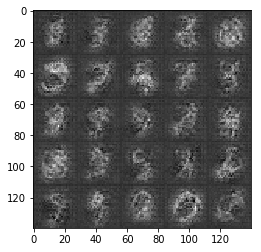

Epoch 0/2... Discriminator Loss: 0.6152... Generator Loss: 1.4950
Epoch 0/2... Discriminator Loss: 0.3908... Generator Loss: 3.0318
Epoch 0/2... Discriminator Loss: 0.4373... Generator Loss: 2.7230
Epoch 0/2... Discriminator Loss: 0.3807... Generator Loss: 3.4663
Epoch 0/2... Discriminator Loss: 0.3701... Generator Loss: 3.6134
Epoch 0/2... Discriminator Loss: 0.3957... Generator Loss: 2.9180
Epoch 0/2... Discriminator Loss: 1.2801... Generator Loss: 0.6547
Epoch 0/2... Discriminator Loss: 0.9123... Generator Loss: 1.1201
Epoch 0/2... Discriminator Loss: 0.7374... Generator Loss: 1.3820
Epoch 0/2... Discriminator Loss: 0.9800... Generator Loss: 0.8778


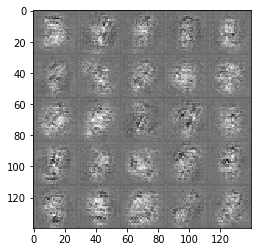

Epoch 0/2... Discriminator Loss: 0.6669... Generator Loss: 1.4313
Epoch 0/2... Discriminator Loss: 0.6674... Generator Loss: 1.5197
Epoch 0/2... Discriminator Loss: 0.4620... Generator Loss: 2.4369
Epoch 0/2... Discriminator Loss: 0.4784... Generator Loss: 2.3511
Epoch 0/2... Discriminator Loss: 0.3657... Generator Loss: 3.6644
Epoch 0/2... Discriminator Loss: 0.3436... Generator Loss: 4.8978
Epoch 0/2... Discriminator Loss: 0.8090... Generator Loss: 1.0747
Epoch 0/2... Discriminator Loss: 0.3888... Generator Loss: 5.0359
Epoch 0/2... Discriminator Loss: 1.1907... Generator Loss: 1.2774
Epoch 0/2... Discriminator Loss: 0.7318... Generator Loss: 1.7348


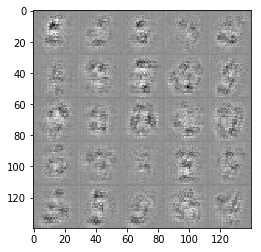

Epoch 0/2... Discriminator Loss: 0.5973... Generator Loss: 1.8816
Epoch 0/2... Discriminator Loss: 0.3821... Generator Loss: 3.7959
Epoch 0/2... Discriminator Loss: 0.5984... Generator Loss: 1.5599
Epoch 0/2... Discriminator Loss: 0.4841... Generator Loss: 2.3547
Epoch 0/2... Discriminator Loss: 0.3773... Generator Loss: 3.4051
Epoch 0/2... Discriminator Loss: 0.4231... Generator Loss: 3.6377
Epoch 0/2... Discriminator Loss: 1.4920... Generator Loss: 0.5364
Epoch 0/2... Discriminator Loss: 1.0770... Generator Loss: 0.7959
Epoch 0/2... Discriminator Loss: 0.6890... Generator Loss: 1.4310
Epoch 0/2... Discriminator Loss: 0.8711... Generator Loss: 3.2358


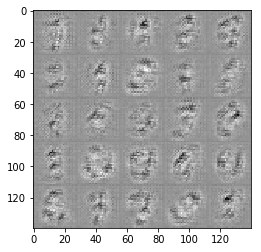

Epoch 0/2... Discriminator Loss: 0.9026... Generator Loss: 0.9631
Epoch 0/2... Discriminator Loss: 0.9478... Generator Loss: 0.8954
Epoch 0/2... Discriminator Loss: 1.2772... Generator Loss: 0.5928
Epoch 0/2... Discriminator Loss: 0.9792... Generator Loss: 1.8918
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 0.6222... Generator Loss: 1.7938
Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 1.3831
Epoch 1/2... Discriminator Loss: 0.3411... Generator Loss: 6.2704
Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 3.2238
Epoch 1/2... Discriminator Loss: 0.6584... Generator Loss: 1.4570


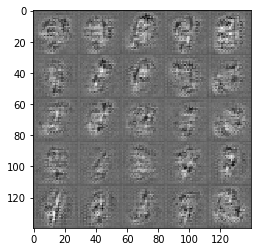

Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 0.4564... Generator Loss: 2.3760
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 5.0548
Epoch 1/2... Discriminator Loss: 0.3425... Generator Loss: 5.8106
Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 2.5249
Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 4.6743
Epoch 1/2... Discriminator Loss: 3.3632... Generator Loss: 0.1023
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.6669


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.8622... Generator Loss: 1.2482
Epoch 0/1... Discriminator Loss: 0.6628... Generator Loss: 1.7252
Epoch 0/1... Discriminator Loss: 0.5561... Generator Loss: 2.9866
Epoch 0/1... Discriminator Loss: 0.7498... Generator Loss: 2.0211
Epoch 0/1... Discriminator Loss: 0.5525... Generator Loss: 3.2963
Epoch 0/1... Discriminator Loss: 0.6056... Generator Loss: 1.8847
Epoch 0/1... Discriminator Loss: 0.4183... Generator Loss: 3.4025
Epoch 0/1... Discriminator Loss: 0.4471... Generator Loss: 3.1808
Epoch 0/1... Discriminator Loss: 0.4349... Generator Loss: 3.0548


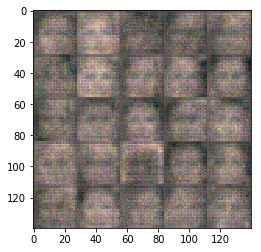

Epoch 0/1... Discriminator Loss: 0.4392... Generator Loss: 2.7199
Epoch 0/1... Discriminator Loss: 0.4353... Generator Loss: 2.5855
Epoch 0/1... Discriminator Loss: 0.5635... Generator Loss: 5.8146
Epoch 0/1... Discriminator Loss: 0.5998... Generator Loss: 2.4794
Epoch 0/1... Discriminator Loss: 0.3766... Generator Loss: 3.8678
Epoch 0/1... Discriminator Loss: 0.8273... Generator Loss: 8.4225
Epoch 0/1... Discriminator Loss: 0.3402... Generator Loss: 7.0086
Epoch 0/1... Discriminator Loss: 0.8007... Generator Loss: 2.7636
Epoch 0/1... Discriminator Loss: 0.3649... Generator Loss: 10.0393
Epoch 0/1... Discriminator Loss: 0.3614... Generator Loss: 4.2783


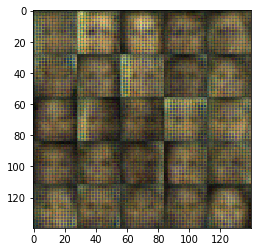

Epoch 0/1... Discriminator Loss: 0.5188... Generator Loss: 2.7915
Epoch 0/1... Discriminator Loss: 2.6520... Generator Loss: 5.4350
Epoch 0/1... Discriminator Loss: 0.3483... Generator Loss: 8.1511
Epoch 0/1... Discriminator Loss: 0.7192... Generator Loss: 1.7822
Epoch 0/1... Discriminator Loss: 0.3963... Generator Loss: 3.8055
Epoch 0/1... Discriminator Loss: 1.1798... Generator Loss: 0.6694
Epoch 0/1... Discriminator Loss: 0.9415... Generator Loss: 0.8822
Epoch 0/1... Discriminator Loss: 0.4744... Generator Loss: 4.7454
Epoch 0/1... Discriminator Loss: 0.4079... Generator Loss: 8.1879
Epoch 0/1... Discriminator Loss: 0.3519... Generator Loss: 9.0287


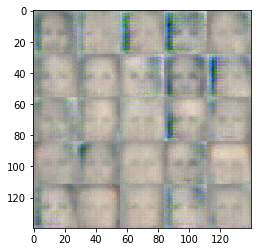

Epoch 0/1... Discriminator Loss: 0.4496... Generator Loss: 5.5759
Epoch 0/1... Discriminator Loss: 0.3983... Generator Loss: 8.5014
Epoch 0/1... Discriminator Loss: 2.4449... Generator Loss: 0.2133
Epoch 0/1... Discriminator Loss: 2.4927... Generator Loss: 1.1453
Epoch 0/1... Discriminator Loss: 0.9073... Generator Loss: 0.9987
Epoch 0/1... Discriminator Loss: 0.8587... Generator Loss: 1.1248
Epoch 0/1... Discriminator Loss: 0.3723... Generator Loss: 3.9236
Epoch 0/1... Discriminator Loss: 0.5713... Generator Loss: 3.4677
Epoch 0/1... Discriminator Loss: 0.5127... Generator Loss: 2.1418
Epoch 0/1... Discriminator Loss: 0.4836... Generator Loss: 6.8964


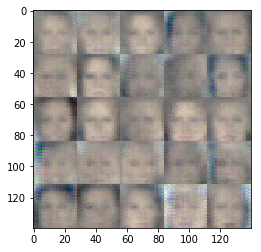

Epoch 0/1... Discriminator Loss: 0.6949... Generator Loss: 1.9499
Epoch 0/1... Discriminator Loss: 0.6868... Generator Loss: 1.5032
Epoch 0/1... Discriminator Loss: 0.4078... Generator Loss: 4.0948
Epoch 0/1... Discriminator Loss: 0.3846... Generator Loss: 6.9241
Epoch 0/1... Discriminator Loss: 0.7998... Generator Loss: 1.1906
Epoch 0/1... Discriminator Loss: 0.3525... Generator Loss: 9.4798
Epoch 0/1... Discriminator Loss: 0.7534... Generator Loss: 1.3671
Epoch 0/1... Discriminator Loss: 0.4055... Generator Loss: 3.2200
Epoch 0/1... Discriminator Loss: 0.3589... Generator Loss: 4.8037
Epoch 0/1... Discriminator Loss: 3.3049... Generator Loss: 2.6378


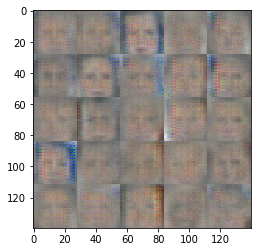

Epoch 0/1... Discriminator Loss: 0.9423... Generator Loss: 1.7923
Epoch 0/1... Discriminator Loss: 0.6018... Generator Loss: 1.8139
Epoch 0/1... Discriminator Loss: 0.3867... Generator Loss: 3.7583
Epoch 0/1... Discriminator Loss: 0.8095... Generator Loss: 1.6888
Epoch 0/1... Discriminator Loss: 2.2706... Generator Loss: 0.2481
Epoch 0/1... Discriminator Loss: 0.5089... Generator Loss: 2.0634
Epoch 0/1... Discriminator Loss: 1.2246... Generator Loss: 0.6395
Epoch 0/1... Discriminator Loss: 0.3699... Generator Loss: 4.8553
Epoch 0/1... Discriminator Loss: 0.7002... Generator Loss: 6.9481
Epoch 0/1... Discriminator Loss: 0.8562... Generator Loss: 1.6526


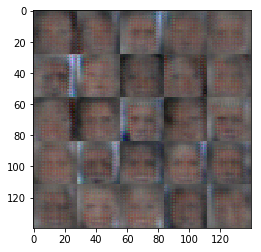

Epoch 0/1... Discriminator Loss: 1.0188... Generator Loss: 0.7983
Epoch 0/1... Discriminator Loss: 0.3561... Generator Loss: 5.8120
Epoch 0/1... Discriminator Loss: 0.5232... Generator Loss: 1.8632
Epoch 0/1... Discriminator Loss: 0.5532... Generator Loss: 2.0435
Epoch 0/1... Discriminator Loss: 1.2677... Generator Loss: 3.5026
Epoch 0/1... Discriminator Loss: 0.6942... Generator Loss: 1.4519
Epoch 0/1... Discriminator Loss: 0.4055... Generator Loss: 3.3248
Epoch 0/1... Discriminator Loss: 0.6994... Generator Loss: 3.9289
Epoch 0/1... Discriminator Loss: 0.6659... Generator Loss: 2.2418
Epoch 0/1... Discriminator Loss: 0.3390... Generator Loss: 8.3960


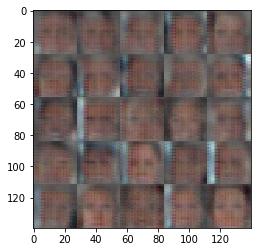

Epoch 0/1... Discriminator Loss: 0.8200... Generator Loss: 1.0808
Epoch 0/1... Discriminator Loss: 0.3969... Generator Loss: 3.2654
Epoch 0/1... Discriminator Loss: 0.3455... Generator Loss: 9.4413
Epoch 0/1... Discriminator Loss: 1.9420... Generator Loss: 0.2891
Epoch 0/1... Discriminator Loss: 0.5400... Generator Loss: 2.5219
Epoch 0/1... Discriminator Loss: 0.6703... Generator Loss: 1.5095
Epoch 0/1... Discriminator Loss: 0.8161... Generator Loss: 1.1281
Epoch 0/1... Discriminator Loss: 0.7006... Generator Loss: 1.3845
Epoch 0/1... Discriminator Loss: 0.3617... Generator Loss: 4.6969
Epoch 0/1... Discriminator Loss: 0.7486... Generator Loss: 2.6265


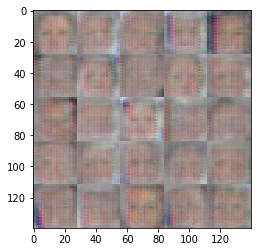

Epoch 0/1... Discriminator Loss: 1.2906... Generator Loss: 0.5392
Epoch 0/1... Discriminator Loss: 1.1407... Generator Loss: 0.6625
Epoch 0/1... Discriminator Loss: 0.3769... Generator Loss: 3.6662
Epoch 0/1... Discriminator Loss: 1.0141... Generator Loss: 9.1362
Epoch 0/1... Discriminator Loss: 0.9953... Generator Loss: 0.8942
Epoch 0/1... Discriminator Loss: 0.8943... Generator Loss: 0.9990
Epoch 0/1... Discriminator Loss: 0.4787... Generator Loss: 2.2965
Epoch 0/1... Discriminator Loss: 0.4455... Generator Loss: 2.6056
Epoch 0/1... Discriminator Loss: 0.3852... Generator Loss: 7.4217
Epoch 0/1... Discriminator Loss: 0.8851... Generator Loss: 1.0772


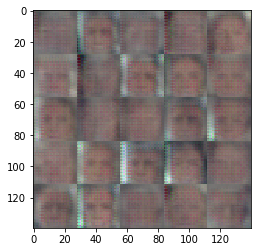

Epoch 0/1... Discriminator Loss: 0.3366... Generator Loss: 8.2460
Epoch 0/1... Discriminator Loss: 0.5263... Generator Loss: 1.9322
Epoch 0/1... Discriminator Loss: 0.7344... Generator Loss: 5.2783
Epoch 0/1... Discriminator Loss: 0.3620... Generator Loss: 5.2147
Epoch 0/1... Discriminator Loss: 0.8920... Generator Loss: 0.9274
Epoch 0/1... Discriminator Loss: 0.7073... Generator Loss: 1.2831
Epoch 0/1... Discriminator Loss: 0.5442... Generator Loss: 1.7806
Epoch 0/1... Discriminator Loss: 0.5930... Generator Loss: 8.0101
Epoch 0/1... Discriminator Loss: 0.3762... Generator Loss: 6.4059
Epoch 0/1... Discriminator Loss: 0.5545... Generator Loss: 1.8242


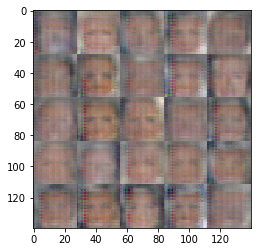

Epoch 0/1... Discriminator Loss: 0.3469... Generator Loss: 6.0424
Epoch 0/1... Discriminator Loss: 2.4629... Generator Loss: 2.6340
Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 1.1997
Epoch 0/1... Discriminator Loss: 0.5280... Generator Loss: 5.7375
Epoch 0/1... Discriminator Loss: 0.8987... Generator Loss: 0.9700
Epoch 0/1... Discriminator Loss: 0.5534... Generator Loss: 4.0575
Epoch 0/1... Discriminator Loss: 0.3791... Generator Loss: 5.5815
Epoch 0/1... Discriminator Loss: 3.4269... Generator Loss: 5.8132
Epoch 0/1... Discriminator Loss: 0.4481... Generator Loss: 8.9749
Epoch 0/1... Discriminator Loss: 0.3433... Generator Loss: 5.2254


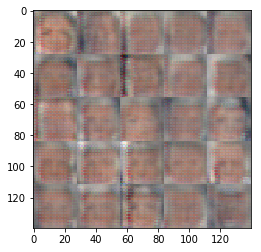

Epoch 0/1... Discriminator Loss: 0.3595... Generator Loss: 3.9170
Epoch 0/1... Discriminator Loss: 1.1702... Generator Loss: 0.6115
Epoch 0/1... Discriminator Loss: 0.3370... Generator Loss: 8.0415
Epoch 0/1... Discriminator Loss: 0.4470... Generator Loss: 5.6200
Epoch 0/1... Discriminator Loss: 0.8503... Generator Loss: 1.2406
Epoch 0/1... Discriminator Loss: 0.5893... Generator Loss: 1.5791
Epoch 0/1... Discriminator Loss: 0.3849... Generator Loss: 4.3241
Epoch 0/1... Discriminator Loss: 0.7295... Generator Loss: 1.1908
Epoch 0/1... Discriminator Loss: 1.1091... Generator Loss: 0.6718
Epoch 0/1... Discriminator Loss: 0.3861... Generator Loss: 4.5464


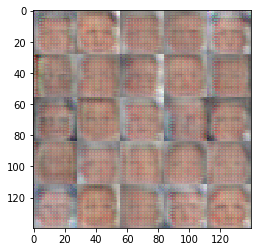

Epoch 0/1... Discriminator Loss: 0.4190... Generator Loss: 2.5776
Epoch 0/1... Discriminator Loss: 0.3603... Generator Loss: 3.8237
Epoch 0/1... Discriminator Loss: 0.3496... Generator Loss: 5.0269
Epoch 0/1... Discriminator Loss: 0.3501... Generator Loss: 4.8594
Epoch 0/1... Discriminator Loss: 0.6613... Generator Loss: 2.9546
Epoch 0/1... Discriminator Loss: 0.5128... Generator Loss: 1.9819
Epoch 0/1... Discriminator Loss: 2.0672... Generator Loss: 3.5556
Epoch 0/1... Discriminator Loss: 0.7999... Generator Loss: 1.1119
Epoch 0/1... Discriminator Loss: 0.6075... Generator Loss: 1.5121
Epoch 0/1... Discriminator Loss: 0.6209... Generator Loss: 1.4919


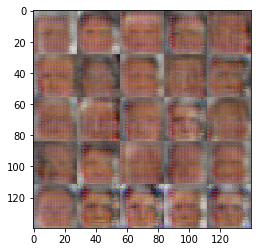

Epoch 0/1... Discriminator Loss: 0.3435... Generator Loss: 7.1619
Epoch 0/1... Discriminator Loss: 0.9744... Generator Loss: 4.2263
Epoch 0/1... Discriminator Loss: 1.0819... Generator Loss: 1.3436
Epoch 0/1... Discriminator Loss: 0.8555... Generator Loss: 1.3359
Epoch 0/1... Discriminator Loss: 0.3859... Generator Loss: 3.3264
Epoch 0/1... Discriminator Loss: 0.6818... Generator Loss: 1.4163
Epoch 0/1... Discriminator Loss: 0.5185... Generator Loss: 1.8496
Epoch 0/1... Discriminator Loss: 0.4332... Generator Loss: 6.4725
Epoch 0/1... Discriminator Loss: 0.4374... Generator Loss: 2.5078
Epoch 0/1... Discriminator Loss: 0.3747... Generator Loss: 3.3142


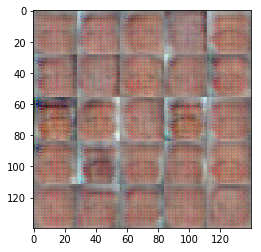

Epoch 0/1... Discriminator Loss: 0.4294... Generator Loss: 5.6556
Epoch 0/1... Discriminator Loss: 1.2924... Generator Loss: 1.3512
Epoch 0/1... Discriminator Loss: 0.7478... Generator Loss: 1.2428
Epoch 0/1... Discriminator Loss: 1.4407... Generator Loss: 0.4633
Epoch 0/1... Discriminator Loss: 0.4050... Generator Loss: 3.1921
Epoch 0/1... Discriminator Loss: 0.4021... Generator Loss: 3.4101
Epoch 0/1... Discriminator Loss: 0.3391... Generator Loss: 5.7532
Epoch 0/1... Discriminator Loss: 1.3101... Generator Loss: 0.5299
Epoch 0/1... Discriminator Loss: 0.3670... Generator Loss: 5.5770
Epoch 0/1... Discriminator Loss: 0.9065... Generator Loss: 5.7605


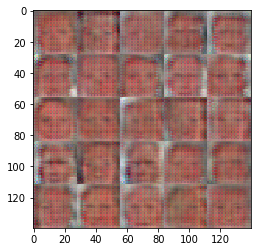

Epoch 0/1... Discriminator Loss: 0.4870... Generator Loss: 3.3277
Epoch 0/1... Discriminator Loss: 0.5848... Generator Loss: 1.7078
Epoch 0/1... Discriminator Loss: 0.9105... Generator Loss: 0.9194
Epoch 0/1... Discriminator Loss: 0.7868... Generator Loss: 2.7159
Epoch 0/1... Discriminator Loss: 0.7807... Generator Loss: 2.8663
Epoch 0/1... Discriminator Loss: 0.8324... Generator Loss: 1.0261
Epoch 0/1... Discriminator Loss: 0.4461... Generator Loss: 3.0502
Epoch 0/1... Discriminator Loss: 0.5796... Generator Loss: 1.6908
Epoch 0/1... Discriminator Loss: 0.3404... Generator Loss: 5.8665
Epoch 0/1... Discriminator Loss: 0.4618... Generator Loss: 3.2364


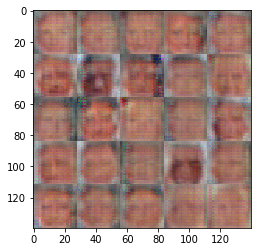

Epoch 0/1... Discriminator Loss: 0.3570... Generator Loss: 8.2689
Epoch 0/1... Discriminator Loss: 0.3586... Generator Loss: 8.1128
Epoch 0/1... Discriminator Loss: 1.1642... Generator Loss: 2.6272
Epoch 0/1... Discriminator Loss: 0.8376... Generator Loss: 1.4271
Epoch 0/1... Discriminator Loss: 0.4455... Generator Loss: 2.7665
Epoch 0/1... Discriminator Loss: 1.5639... Generator Loss: 1.3933
Epoch 0/1... Discriminator Loss: 1.9304... Generator Loss: 0.2570
Epoch 0/1... Discriminator Loss: 0.5246... Generator Loss: 2.0324
Epoch 0/1... Discriminator Loss: 0.3903... Generator Loss: 3.3156
Epoch 0/1... Discriminator Loss: 1.2014... Generator Loss: 1.6969


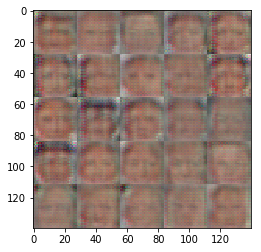

Epoch 0/1... Discriminator Loss: 0.6763... Generator Loss: 1.4203
Epoch 0/1... Discriminator Loss: 0.5008... Generator Loss: 2.0770
Epoch 0/1... Discriminator Loss: 0.7305... Generator Loss: 6.4727
Epoch 0/1... Discriminator Loss: 1.2833... Generator Loss: 0.7608
Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.8713
Epoch 0/1... Discriminator Loss: 1.2399... Generator Loss: 1.6543
Epoch 0/1... Discriminator Loss: 0.5532... Generator Loss: 3.3911
Epoch 0/1... Discriminator Loss: 0.4129... Generator Loss: 2.9621
Epoch 0/1... Discriminator Loss: 0.7868... Generator Loss: 1.2178
Epoch 0/1... Discriminator Loss: 0.6746... Generator Loss: 1.4105


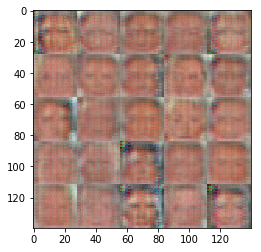

Epoch 0/1... Discriminator Loss: 1.2605... Generator Loss: 1.5299
Epoch 0/1... Discriminator Loss: 0.3901... Generator Loss: 4.2318
Epoch 0/1... Discriminator Loss: 0.4094... Generator Loss: 3.4740
Epoch 0/1... Discriminator Loss: 0.9323... Generator Loss: 0.9509
Epoch 0/1... Discriminator Loss: 0.5357... Generator Loss: 4.0975
Epoch 0/1... Discriminator Loss: 0.9193... Generator Loss: 0.9180
Epoch 0/1... Discriminator Loss: 1.0355... Generator Loss: 0.9310
Epoch 0/1... Discriminator Loss: 0.4603... Generator Loss: 2.3700
Epoch 0/1... Discriminator Loss: 0.5923... Generator Loss: 1.6369
Epoch 0/1... Discriminator Loss: 1.0785... Generator Loss: 0.7974


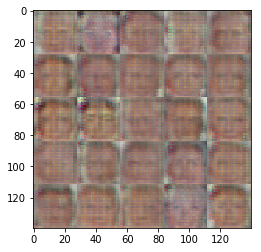

Epoch 0/1... Discriminator Loss: 0.9521... Generator Loss: 0.8773
Epoch 0/1... Discriminator Loss: 0.3589... Generator Loss: 5.8879
Epoch 0/1... Discriminator Loss: 1.1698... Generator Loss: 0.7256
Epoch 0/1... Discriminator Loss: 2.1712... Generator Loss: 4.4421
Epoch 0/1... Discriminator Loss: 0.3762... Generator Loss: 3.8950
Epoch 0/1... Discriminator Loss: 0.4925... Generator Loss: 2.2220
Epoch 0/1... Discriminator Loss: 0.4284... Generator Loss: 2.7058
Epoch 0/1... Discriminator Loss: 0.4147... Generator Loss: 2.7168
Epoch 0/1... Discriminator Loss: 1.5120... Generator Loss: 1.8530
Epoch 0/1... Discriminator Loss: 0.4069... Generator Loss: 3.4533


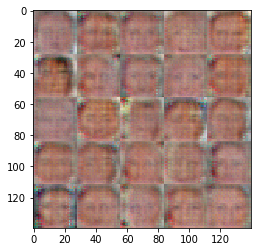

Epoch 0/1... Discriminator Loss: 0.4527... Generator Loss: 2.3984
Epoch 0/1... Discriminator Loss: 0.3992... Generator Loss: 3.2696
Epoch 0/1... Discriminator Loss: 1.5446... Generator Loss: 0.4199
Epoch 0/1... Discriminator Loss: 1.0300... Generator Loss: 0.8090
Epoch 0/1... Discriminator Loss: 0.6020... Generator Loss: 2.9766
Epoch 0/1... Discriminator Loss: 0.5670... Generator Loss: 3.2599
Epoch 0/1... Discriminator Loss: 1.3132... Generator Loss: 0.5389
Epoch 0/1... Discriminator Loss: 1.3980... Generator Loss: 4.2283
Epoch 0/1... Discriminator Loss: 0.4363... Generator Loss: 5.3151
Epoch 0/1... Discriminator Loss: 0.3972... Generator Loss: 3.2703


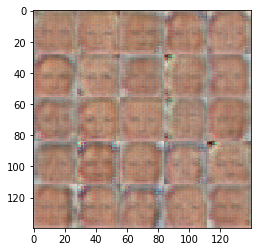

Epoch 0/1... Discriminator Loss: 0.9978... Generator Loss: 1.3656
Epoch 0/1... Discriminator Loss: 0.6602... Generator Loss: 3.9425
Epoch 0/1... Discriminator Loss: 0.3654... Generator Loss: 3.7343
Epoch 0/1... Discriminator Loss: 1.2591... Generator Loss: 1.7725
Epoch 0/1... Discriminator Loss: 0.5658... Generator Loss: 4.2944
Epoch 0/1... Discriminator Loss: 0.4794... Generator Loss: 4.2207
Epoch 0/1... Discriminator Loss: 0.5894... Generator Loss: 1.7877
Epoch 0/1... Discriminator Loss: 0.4928... Generator Loss: 6.0793
Epoch 0/1... Discriminator Loss: 0.3564... Generator Loss: 4.4053
Epoch 0/1... Discriminator Loss: 0.3647... Generator Loss: 3.7891


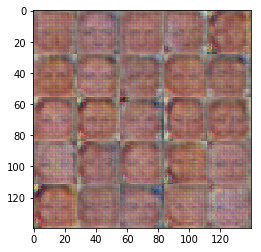

Epoch 0/1... Discriminator Loss: 1.2335... Generator Loss: 6.3863
Epoch 0/1... Discriminator Loss: 1.7457... Generator Loss: 0.3164
Epoch 0/1... Discriminator Loss: 0.4542... Generator Loss: 3.2477
Epoch 0/1... Discriminator Loss: 0.3987... Generator Loss: 4.0471
Epoch 0/1... Discriminator Loss: 0.4683... Generator Loss: 2.2826
Epoch 0/1... Discriminator Loss: 0.8865... Generator Loss: 5.8543
Epoch 0/1... Discriminator Loss: 0.4902... Generator Loss: 4.3951
Epoch 0/1... Discriminator Loss: 0.3617... Generator Loss: 3.8338
Epoch 0/1... Discriminator Loss: 0.3540... Generator Loss: 5.3783
Epoch 0/1... Discriminator Loss: 1.0182... Generator Loss: 1.1152


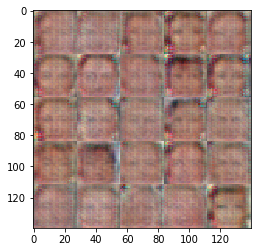

Epoch 0/1... Discriminator Loss: 0.6242... Generator Loss: 3.0261
Epoch 0/1... Discriminator Loss: 0.3944... Generator Loss: 3.5952
Epoch 0/1... Discriminator Loss: 1.0208... Generator Loss: 1.0449
Epoch 0/1... Discriminator Loss: 0.7446... Generator Loss: 1.2049
Epoch 0/1... Discriminator Loss: 0.5701... Generator Loss: 7.2047
Epoch 0/1... Discriminator Loss: 0.3665... Generator Loss: 4.7079
Epoch 0/1... Discriminator Loss: 0.4106... Generator Loss: 3.5682
Epoch 0/1... Discriminator Loss: 1.1137... Generator Loss: 0.7214
Epoch 0/1... Discriminator Loss: 0.7811... Generator Loss: 2.1764
Epoch 0/1... Discriminator Loss: 0.7077... Generator Loss: 1.3095


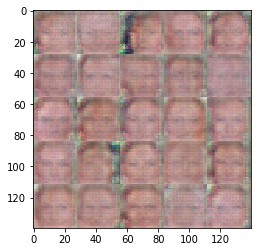

Epoch 0/1... Discriminator Loss: 1.0223... Generator Loss: 0.8784
Epoch 0/1... Discriminator Loss: 1.6429... Generator Loss: 0.3464
Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 2.8770
Epoch 0/1... Discriminator Loss: 0.5279... Generator Loss: 6.9461
Epoch 0/1... Discriminator Loss: 1.1103... Generator Loss: 0.7549
Epoch 0/1... Discriminator Loss: 0.4765... Generator Loss: 2.6159
Epoch 0/1... Discriminator Loss: 0.7434... Generator Loss: 3.8003
Epoch 0/1... Discriminator Loss: 0.3487... Generator Loss: 5.2843
Epoch 0/1... Discriminator Loss: 1.5188... Generator Loss: 7.8837
Epoch 0/1... Discriminator Loss: 0.7316... Generator Loss: 1.4602


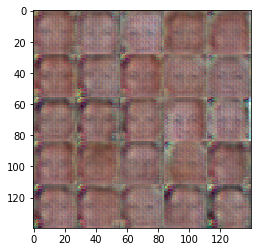

Epoch 0/1... Discriminator Loss: 0.4711... Generator Loss: 3.1587
Epoch 0/1... Discriminator Loss: 0.6539... Generator Loss: 1.5198
Epoch 0/1... Discriminator Loss: 0.7109... Generator Loss: 1.9455
Epoch 0/1... Discriminator Loss: 0.3783... Generator Loss: 3.7271
Epoch 0/1... Discriminator Loss: 1.1665... Generator Loss: 0.6293
Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 0.8950
Epoch 0/1... Discriminator Loss: 1.0489... Generator Loss: 0.7991
Epoch 0/1... Discriminator Loss: 0.5220... Generator Loss: 3.0845
Epoch 0/1... Discriminator Loss: 0.4455... Generator Loss: 2.7429
Epoch 0/1... Discriminator Loss: 1.8285... Generator Loss: 0.3234


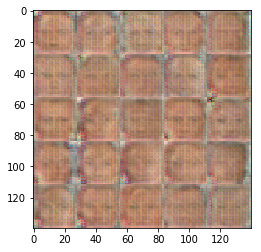

Epoch 0/1... Discriminator Loss: 1.5035... Generator Loss: 0.5433
Epoch 0/1... Discriminator Loss: 0.8556... Generator Loss: 1.2443
Epoch 0/1... Discriminator Loss: 0.5342... Generator Loss: 2.1756
Epoch 0/1... Discriminator Loss: 0.6534... Generator Loss: 1.6794
Epoch 0/1... Discriminator Loss: 0.6317... Generator Loss: 1.5035
Epoch 0/1... Discriminator Loss: 0.3990... Generator Loss: 3.6051
Epoch 0/1... Discriminator Loss: 0.7003... Generator Loss: 2.2381
Epoch 0/1... Discriminator Loss: 1.0009... Generator Loss: 0.7955
Epoch 0/1... Discriminator Loss: 0.4229... Generator Loss: 3.2611
Epoch 0/1... Discriminator Loss: 1.0737... Generator Loss: 1.0497


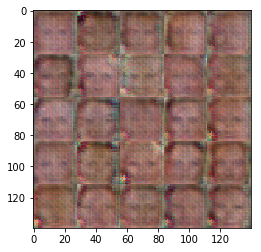

Epoch 0/1... Discriminator Loss: 0.8002... Generator Loss: 2.6528
Epoch 0/1... Discriminator Loss: 1.1500... Generator Loss: 0.6890
Epoch 0/1... Discriminator Loss: 0.5735... Generator Loss: 1.9478
Epoch 0/1... Discriminator Loss: 0.5451... Generator Loss: 1.9929
Epoch 0/1... Discriminator Loss: 0.8339... Generator Loss: 1.0395
Epoch 0/1... Discriminator Loss: 0.3949... Generator Loss: 3.9667
Epoch 0/1... Discriminator Loss: 0.7052... Generator Loss: 2.0302
Epoch 0/1... Discriminator Loss: 1.0266... Generator Loss: 1.1606
Epoch 0/1... Discriminator Loss: 0.6225... Generator Loss: 2.1081
Epoch 0/1... Discriminator Loss: 0.5373... Generator Loss: 1.8720


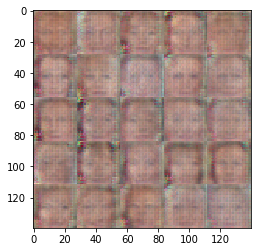

Epoch 0/1... Discriminator Loss: 0.9037... Generator Loss: 1.0250
Epoch 0/1... Discriminator Loss: 0.3413... Generator Loss: 5.4927
Epoch 0/1... Discriminator Loss: 0.7475... Generator Loss: 1.2696
Epoch 0/1... Discriminator Loss: 1.5603... Generator Loss: 0.4186
Epoch 0/1... Discriminator Loss: 0.3490... Generator Loss: 5.1329
Epoch 0/1... Discriminator Loss: 1.7014... Generator Loss: 0.3237
Epoch 0/1... Discriminator Loss: 0.5686... Generator Loss: 2.1533
Epoch 0/1... Discriminator Loss: 1.1988... Generator Loss: 0.5937
Epoch 0/1... Discriminator Loss: 0.6740... Generator Loss: 1.3298
Epoch 0/1... Discriminator Loss: 0.6557... Generator Loss: 1.5503


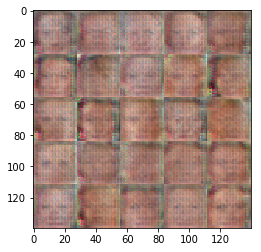

Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 0.7521
Epoch 0/1... Discriminator Loss: 1.0322... Generator Loss: 0.8152
Epoch 0/1... Discriminator Loss: 0.9511... Generator Loss: 1.7492
Epoch 0/1... Discriminator Loss: 0.7505... Generator Loss: 2.4373
Epoch 0/1... Discriminator Loss: 0.5341... Generator Loss: 6.1841
Epoch 0/1... Discriminator Loss: 0.7257... Generator Loss: 1.3719
Epoch 0/1... Discriminator Loss: 1.1932... Generator Loss: 0.6172
Epoch 0/1... Discriminator Loss: 0.3469... Generator Loss: 5.8179
Epoch 0/1... Discriminator Loss: 0.3868... Generator Loss: 7.2055
Epoch 0/1... Discriminator Loss: 1.1246... Generator Loss: 2.0482


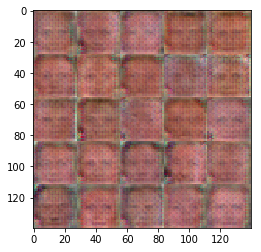

Epoch 0/1... Discriminator Loss: 0.6768... Generator Loss: 1.6408
Epoch 0/1... Discriminator Loss: 0.9922... Generator Loss: 3.8339
Epoch 0/1... Discriminator Loss: 0.3930... Generator Loss: 3.6060
Epoch 0/1... Discriminator Loss: 0.6622... Generator Loss: 2.2152
Epoch 0/1... Discriminator Loss: 0.5816... Generator Loss: 1.8408
Epoch 0/1... Discriminator Loss: 0.4655... Generator Loss: 2.3122
Epoch 0/1... Discriminator Loss: 1.1258... Generator Loss: 1.4244
Epoch 0/1... Discriminator Loss: 0.6477... Generator Loss: 1.8421
Epoch 0/1... Discriminator Loss: 0.5696... Generator Loss: 1.8438
Epoch 0/1... Discriminator Loss: 0.4056... Generator Loss: 3.3750


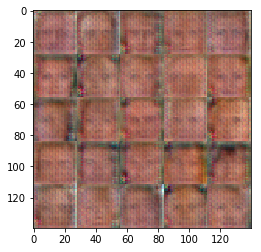

Epoch 0/1... Discriminator Loss: 0.6097... Generator Loss: 1.6771
Epoch 0/1... Discriminator Loss: 1.2555... Generator Loss: 0.8624
Epoch 0/1... Discriminator Loss: 0.6905... Generator Loss: 2.5675
Epoch 0/1... Discriminator Loss: 1.0795... Generator Loss: 0.7637
Epoch 0/1... Discriminator Loss: 1.3652... Generator Loss: 0.4914
Epoch 0/1... Discriminator Loss: 0.6156... Generator Loss: 2.2410
Epoch 0/1... Discriminator Loss: 0.3588... Generator Loss: 4.9518


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.